<h1 align="center">ICA ALGORITHM</h1>

ICA algorithm needs observations that consists of non-gaussian signals and observations in different time segments , in contrast to GPR who can work with 1 observation.
I will create a signal where in every time segment i will make a little slope to the background and i will use off/on calibration so half signals will have the spectral line and half will not.
As a result the observation will be a realistic observation that is slightly changed in every time segment.
Also we will see the duration of the algorithm to compare with others

<div style="
    background-color: #f5f7fa;
    border-left: 6px solid #4a90e2;
    padding: 15px;
    border-radius: 8px;
    font-size: 15px;
    line-height: 1.5;
">

<span style="font-size: 18px; font-weight: bold; color: #1a73e8;">❓:</span><br>
<span style="color: #2b2b2b;">
If I'm already doing ON-OFF observations, why use a complex algorithm like ICA instead of just performing a simple subtraction? 
</span>

<hr style="border: none; border-top: 1px solid #d0d7de; margin: 12px 0;">

<span style="font-size: 18px; font-weight: bold; color: #0f9d58;">✅ Answer:</span><br>
<span style="color: #2b2b2b;">
Simple subtraction fails if the background isn't perfectly stable between the ON and OFF phases, leaving residual errors from the 'drift'. ICA is far more robust because it statistically models this changing background and the ON-OFF signal as two separate, independent components. This allows it to cleanly separate them even when the background varies, while also simultaneously identifying and removing interfering RFI.
</span>

</div>


## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
from scipy.signal import savgol_filter
import time

## Create signal in frequencies 1418 -1422 with 1024 sampples in 200 different time segments

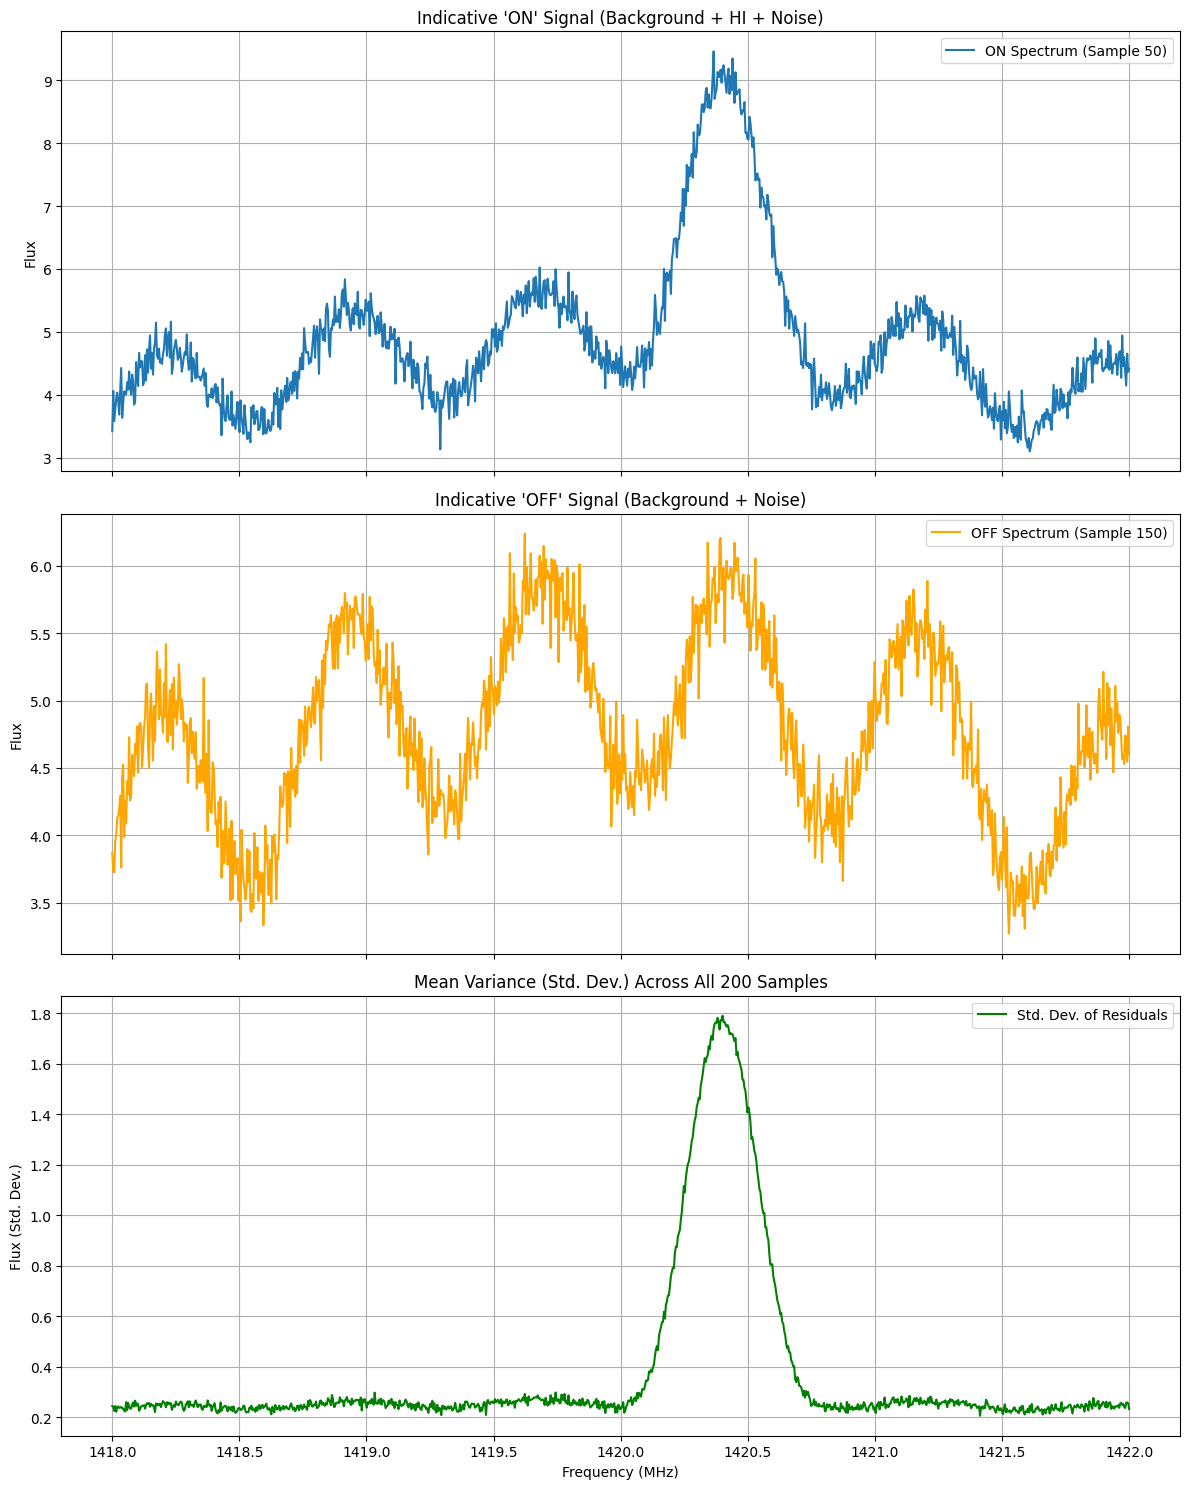

In [2]:
# 1. Frequency axis 
frequencies = np.linspace(1418, 1422, 1024)

# 2. Time Segments
timeSegments = 200

# 3. Signal Components in background
bg_poly = 5.0 - 0.3 * (frequencies - 1420)**2
bg_sine = 0.8 * np.sin(2 * np.pi * (frequencies - 1418) / 0.75)
line = 3.5 * np.exp(-((frequencies - 1420.4)**2) / (2 * 0.15**2))
background = bg_poly+bg_sine

# 4. Creation of mixing Matrix
Mix_Mat = np.array([background,line])

# --- Creation of Time sources ---
# Source 1 : Background "Drift"
background_drift_gaussian = np.random.normal(loc=1,scale=0.1,size=timeSegments)
background_drift = savgol_filter(background_drift_gaussian,21,3) # making the dirft more smooth
# Source 2 : On-Off 
line_signal_activation = np.zeros(timeSegments)
line_signal_activation[:100] = 1 # The first 100 observations are with the spectral line

# --- Mixing the Original Signals With the Time sources ---
# X = timeSources * Mixing Matrix
time_Sources = np.c_[background_drift,line_signal_activation]
y_clean = time_Sources.dot(Mix_Mat)

#Adding Gaussian Noise
y_observed = y_clean + np.random.normal(0,0.2,y_clean.shape)

# --- Plotting 1 On observation and 1 Off just to see the signal and plot the mean variance of residuals to see the differnce between the observations---

# --- 1. Select Example Spectra ---

# Select an 'ON' spectrum (from the first 'n_on' samples)
on_index = 50
on_spectrum = y_observed[on_index, :]

# Select an 'OFF' spectrum (from the samples after 'n_on')
off_index = 150  # e.g., sample 150
off_spectrum = y_observed[off_index, :]

# --- 2. Calculate the Mean Variance (Std. Dev.) ---
mean_observed = np.mean(y_observed, axis=0)
all_residuals = y_observed - mean_observed
residual_std = np.std(all_residuals, axis=0)

# --- 3. Create the 3-Panel Plot ---
# We create 3 rows, 1 column, and share the X-axis
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# --- Plot 1: ON Signal ---
axes[0].plot(frequencies, on_spectrum, label=f"ON Spectrum (Sample {on_index})")
axes[0].set_title("Indicative 'ON' Signal (Background + HI + Noise)")
axes[0].set_ylabel("Flux")
axes[0].legend()
axes[0].grid(True)

# --- Plot 2: OFF Signal ---
axes[1].plot(frequencies, off_spectrum, label=f"OFF Spectrum (Sample {off_index})", color='orange')
axes[1].set_title("Indicative 'OFF' Signal (Background + Noise)")
axes[1].set_ylabel("Flux")
axes[1].legend()
axes[1].grid(True)

# --- Plot 3: Mean Variance ---
axes[2].plot(frequencies, residual_std, label="Std. Dev. of Residuals", color='green')
axes[2].set_title("Mean Variance (Std. Dev.) Across All 200 Samples")
axes[2].set_ylabel("Flux (Std. Dev.)")
axes[2].set_xlabel("Frequency (MHz)")  # X-label only on the last plot
axes[2].legend()
axes[2].grid(True)

# Tidy up the layout
plt.tight_layout()
plt.show()

## Smoothing the Observations

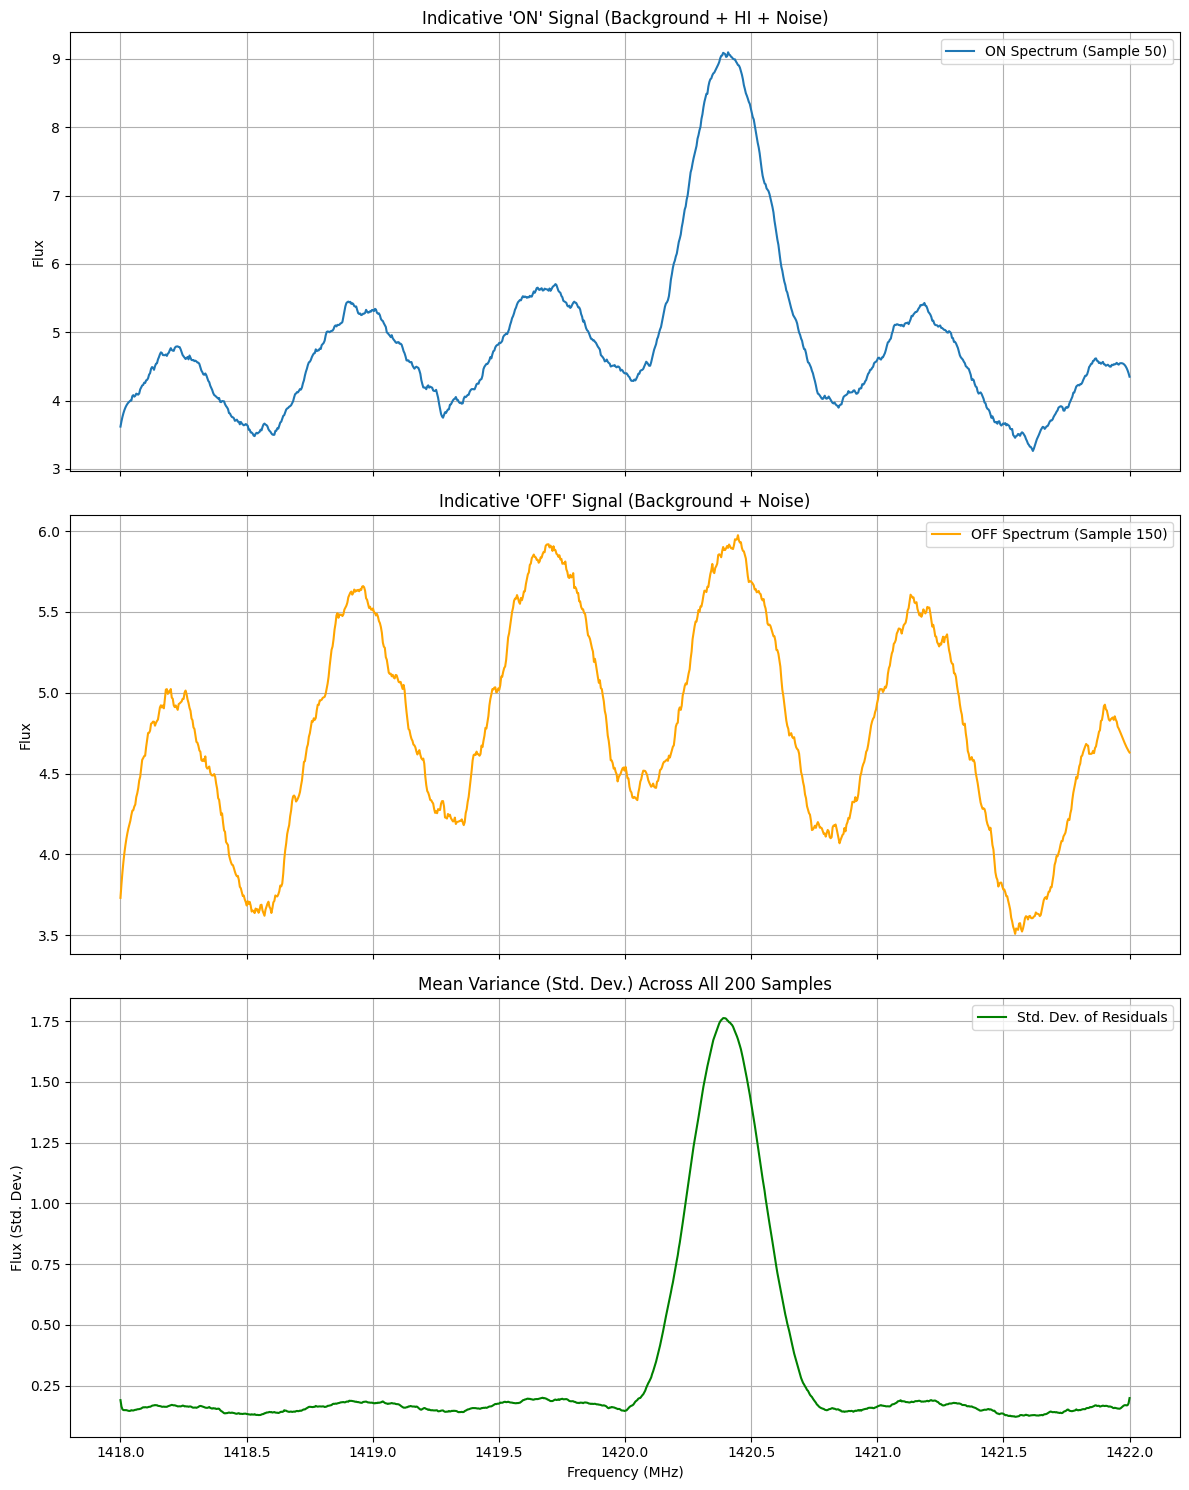

In [3]:
y_observed_smooth = savgol_filter(y_observed,21,3,axis=1)
# --- Plotting 1 On observation and 1 Off just to see the signal and plot the mean variance of residuals to see the differnce between the observations---

# --- 1. Select Example Spectra ---

# Select an 'ON' spectrum (from the first 'n_on' samples)
on_index = 50
on_spectrum_smooth = y_observed_smooth[on_index, :]

# Select an 'OFF' spectrum (from the samples after 'n_on')
off_index = 150  # e.g., sample 150
off_spectrum_smooth = y_observed_smooth[off_index, :]

# --- 2. Calculate the Mean Variance (Std. Dev.) ---
mean_observed_smooth = np.mean(y_observed_smooth, axis=0)
all_residuals_smooth = y_observed_smooth - mean_observed_smooth
residual_std_smooth = np.std(all_residuals_smooth, axis=0)

# --- 3. Create the 3-Panel Plot ---
# We create 3 rows, 1 column, and share the X-axis
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# --- Plot 1: ON Signal ---
axes[0].plot(frequencies, on_spectrum_smooth, label=f"ON Spectrum (Sample {on_index})")
axes[0].set_title("Indicative 'ON' Signal (Background + HI + Noise)")
axes[0].set_ylabel("Flux")
axes[0].legend()
axes[0].grid(True)

# --- Plot 2: OFF Signal ---
axes[1].plot(frequencies, off_spectrum_smooth, label=f"OFF Spectrum (Sample {off_index})", color='orange')
axes[1].set_title("Indicative 'OFF' Signal (Background + Noise)")
axes[1].set_ylabel("Flux")
axes[1].legend()
axes[1].grid(True)

# --- Plot 3: Mean Variance ---
axes[2].plot(frequencies, residual_std_smooth, label="Std. Dev. of Residuals", color='green')
axes[2].set_title("Mean Variance (Std. Dev.) Across All 200 Samples")
axes[2].set_ylabel("Flux (Std. Dev.)")
axes[2].set_xlabel("Frequency (MHz)")  # X-label only on the last plot
axes[2].legend()
axes[2].grid(True)

# Tidy up the layout
plt.tight_layout()
plt.show()

## ICA Algorithm

### Initialization of the ICA Algorithm

In [4]:
print("Initialization of ICA...")
start_time = time.time()
ica = FastICA(
     n_components=2, # In the observation we have 2 components : Background Signal + Spectral Line.In this parameter we tell the algorithm that we want the algorithm to extract 2 differnet signals.
     whiten='unit-variance', # the data must be centraled and whitened before the algorithm.So we put this parameter to show that the data are not whitened and the algorithm will do the work for us.
     random_state=0,
     algorithm='parallel', # the way that the algorithm will find the components. parallel -> simultaneously find the components
     fun='logcosh',# the function of contrast (negentropy)
     max_iter = 200, # max iterations.If we get a warnign that the algorithm didnt coverage we will add iterations
     tol = 1e-4 # coverage limit. 
)
duration = time.time() - start_time
print(f"Initialization Completed! Duration : {duration} sec")

Initialization of ICA...
Initialization Completed! Duration : 0.0 sec


### Algorithm implementation

In [5]:
start_time= time.time()
# The .fit_transform() function does TWO things:
# 1. .fit(): Executes all steps (Centering, Whitening, ICA)
# 2. .transform(): Returns the recovered time sources (S)
S_recovered = ica.fit_transform(y_observed_smooth)
duration = round(time.time() - start_time , 4)
print(f"Algorithm finished in : {duration} sec.")

Algorithm finished in : 0.1325 sec.


### Retrieve and Plot Results

In [6]:
# The "Time Sources" (S) are in S_recovered (shape [200, 3])
# The "Spectral Shapes" (A) are in the .mixing_ array
A_recovered = ica.mixing_


After successfully running FastICA, we have separated our observations into the requested n independent components. However, due to the algorithm's inherent order ambiguity, we don't know which recovered component (A_recovered[:, 0], A_recovered[:, 1], etc.) corresponds to which physical source (e.g., the background, the HI line, or RFI).

Instead of relying on manual plot inspection to identify them, we will implement an automated method to classify these components based on their distinct statistical properties.\
We will Analyze the Kurtosis of the Time Sources (S_recovered).
The Method: Measuring Nongaussianity
Kurtosis measures how "spiky" (non-Gaussian) a signal is. A perfect Gaussian distribution has a kurtosis of 0.

A "spiky" signal (like RFI) has a large positive kurtosis.

A "flat" or bimodal signal (like the ON-OFF signal) has a large negative kurtosis.

An "ordinary" smooth signal (like the Gaussian background drift) will have a kurtosis very close to 0.

This gives us a clear statistical fingerprint to automatically identify each component.

In [7]:
# --- 1. Calculate Kurtosis for Each Time Source ---
# We calculate kurtosis for each *column* (axis=0) of S_recovered
kurtosis_values = kurtosis(S_recovered,axis=0)
for i in range(2):
    print(f"Component {i}: Kurtosis = {kurtosis_values[i]:.4f}")

# --- 2. Automated Identification ---
# We use np.argmin and np.argmax to find the indices

# The Background is the "most Gaussian," so its kurtosis is closest to 0
background_index = np.argmin(np.abs(kurtosis_values))
# The spectral line has the most negative kurtosis
spectral_index = np.argmin(kurtosis_values)
# --- 3. Create Labeled Results ---
background_approach = A_recovered[:,background_index]
spectral_line_approach = A_recovered[:,spectral_index]


Component 0: Kurtosis = -1.9955
Component 1: Kurtosis = -0.5894


### Plot Results

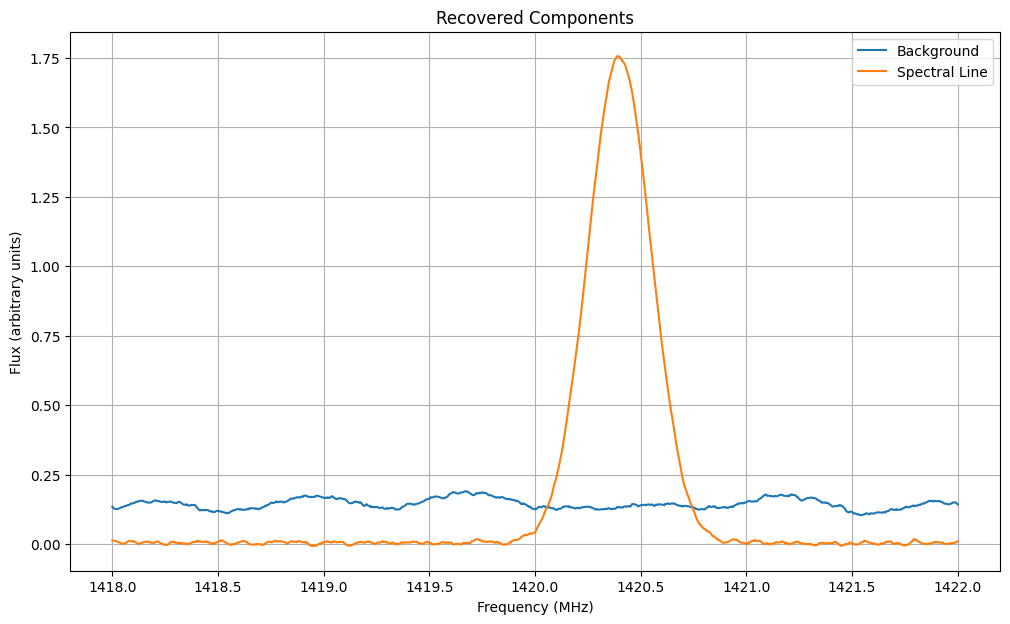

In [8]:
plt.figure(figsize=(12, 7))
plt.title("Recovered Components")
plt.plot(frequencies,background_approach, label="Background")
plt.plot(frequencies,spectral_line_approach, label="Spectral Line")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Flux (arbitrary units)")
plt.legend()
plt.grid(True)
plt.show()

## Error Estimation

We will use Normalized Root Mean Squared Error(NRMSE) to see the error because ICA cannot recover the exact amplitude of the source activity.We will make an overlay plot to see how close is the two lines and a residual plot to see where the algorithm failed and how much

#### Spectral Line

--- Error Estimation ---
Normalized Root Mean Squared Error (NRMSE): 0.00338


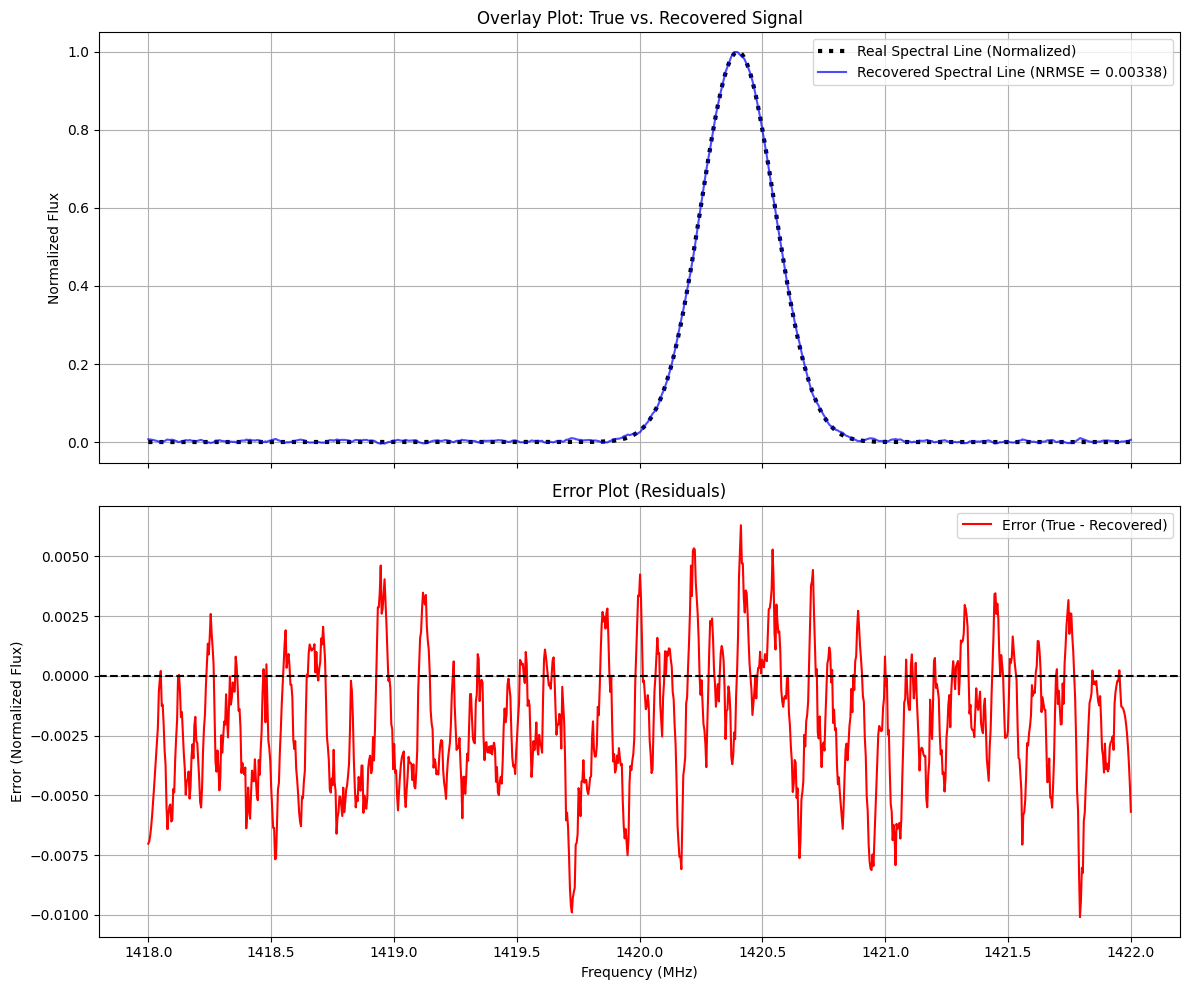

In [9]:
# Normalize the two signals
#spectral line
line_norm = line/np.max(line)
spectral_line_approach_norm = spectral_line_approach/np.max(spectral_line_approach)
rmse = np.sqrt(np.mean((line_norm-spectral_line_approach_norm)**2))
print(f"--- Error Estimation ---")
print(f"Normalized Root Mean Squared Error (NRMSE): {rmse:.5f}")


# --- Plots ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
# Plot 1 : Overlay Plot
axes[0].set_title("Overlay Plot: True vs. Recovered Signal")
axes[0].plot(frequencies, line_norm, 
             label="Real Spectral Line (Normalized)", 
             color='black', linestyle=':', linewidth=3)
axes[0].plot(frequencies, spectral_line_approach_norm, 
             label=f"Recovered Spectral Line (NRMSE = {rmse:.5f})", 
             color='blue', alpha=0.7)
axes[0].set_ylabel("Normalized Flux")
axes[0].legend()
axes[0].grid(True)

#Plot 2 : Residuals
residuals = line_norm - spectral_line_approach_norm
axes[1].set_title("Error Plot (Residuals)")
axes[1].plot(frequencies, residuals, 
             label="Error (True - Recovered)", 
             color='red')
axes[1].axhline(0, color='black', linestyle='--') 
axes[1].set_xlabel("Frequency (MHz)")
axes[1].set_ylabel("Error (Normalized Flux)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### Background Signal

--- Error Estimation ---
Normalized Root Mean Squared Error (NRMSE): 0.08269


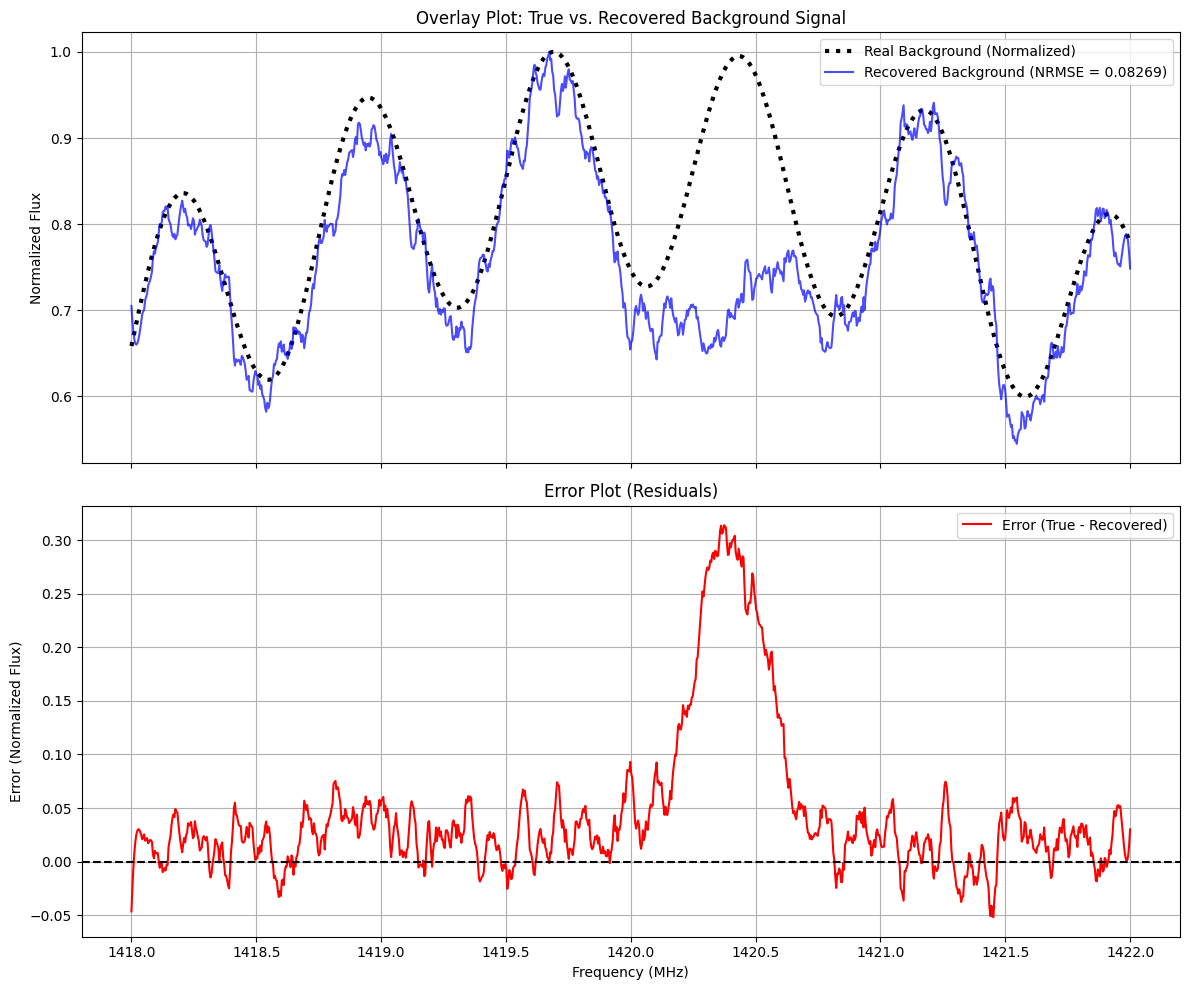

In [10]:
# Normalize the two signals
#Background Signal
background_norm = background/np.max(background)
background_approach_norm = background_approach/np.max(background_approach)
rmse_background = np.sqrt(np.mean((background_norm-background_approach_norm)**2))
print(f"--- Error Estimation ---")
print(f"Normalized Root Mean Squared Error (NRMSE): {rmse_background:.5f}")


# --- Plots ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
# Plot 1 : Overlay Plot
axes[0].set_title("Overlay Plot: True vs. Recovered Background Signal")
axes[0].plot(frequencies, background_norm, 
             label="Real Background (Normalized)", 
             color='black', linestyle=':', linewidth=3)
axes[0].plot(frequencies, background_approach_norm, 
             label=f"Recovered Background (NRMSE = {rmse_background:.5f})", 
             color='blue', alpha=0.7)
axes[0].set_ylabel("Normalized Flux")
axes[0].legend()
axes[0].grid(True)

#Plot 2 : Residuals
residuals2 = background_norm - background_approach_norm
axes[1].set_title("Error Plot (Residuals)")
axes[1].plot(frequencies, residuals2, 
             label="Error (True - Recovered)", 
             color='red')
axes[1].axhline(0, color='black', linestyle='--') 
axes[1].set_xlabel("Frequency (MHz)")
axes[1].set_ylabel("Error (Normalized Flux)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Comments

We can see that ICA succesfully found the original spectral line and the error values where between [0 , 0.015].However in the background component we can see an average performance having error values between [0 , 0.10] for the  minority of the points and error values between [0.10 , 0.25] for the majority of the points.This is very normal and the explanation is this:
ICA is a non-gaussian locator.Our spectral line has a very non-gaussian behaviour in time in contrast to the background that in time has a drift and this is closest to gaussian behavior and that is why the algorithm didnt manage to extract it very succesful.

## Tests

### Test 1 : Change constrast function ( fun parameter)

fun = 'logcosh' -> logcosh is robust and very good for general use for signals that dont have any special behaviour.
fun='cube' -> cube is a faster method but is very vulnerable to outliers
So if we do fun = 'cube' the expected results are the same or slightly better than the logcosh because our signal doesnt have sudden changes like a cosmic ray.
However we must be carefull when to use cube because in case we have a huge tip the algorithm will stuck in the tip and will not manage to extract succesfull the signals.

In [11]:
print("Initialization of ICA...")
start_time = time.time()
ica2 = FastICA(
     n_components=2, # In the observation we have 2 components : Background Signal + Spectral Line.In this parameter we tell the algorithm that we want the algorithm to extract 2 differnet signals.
     whiten='unit-variance', # the data must be centraled and whitened before the algorithm.So we put this parameter to show that the data are not whitened and the algorithm will do the work for us.
     random_state=0,
     algorithm='parallel', # the way that the algorithm will find the components. parallel -> simultaneously find the components
     fun='cube',# the function of contrast (negentropy)
     max_iter = 200, # max iterations.If we get a warnign that the algorithm didnt coverage we will add iterations
     tol = 1e-4 # coverage limit. 
)
duration = time.time() - start_time
print(f"Initialization Completed! Duration : {duration} sec")

Initialization of ICA...
Initialization Completed! Duration : 0.0005297660827636719 sec


In [12]:
start_time= time.time()
# The .fit_transform() function does TWO things:
# 1. .fit(): Executes all steps (Centering, Whitening, ICA)
# 2. .transform(): Returns the recovered time sources (S)
S_recovered2 = ica2.fit_transform(y_observed_smooth)
duration = round(time.time() - start_time , 4)
print(f"Algorithm finished in : {duration} sec.")

Algorithm finished in : 0.2139 sec.


Component 0: Kurtosis = -1.9960
Component 1: Kurtosis = -0.5889


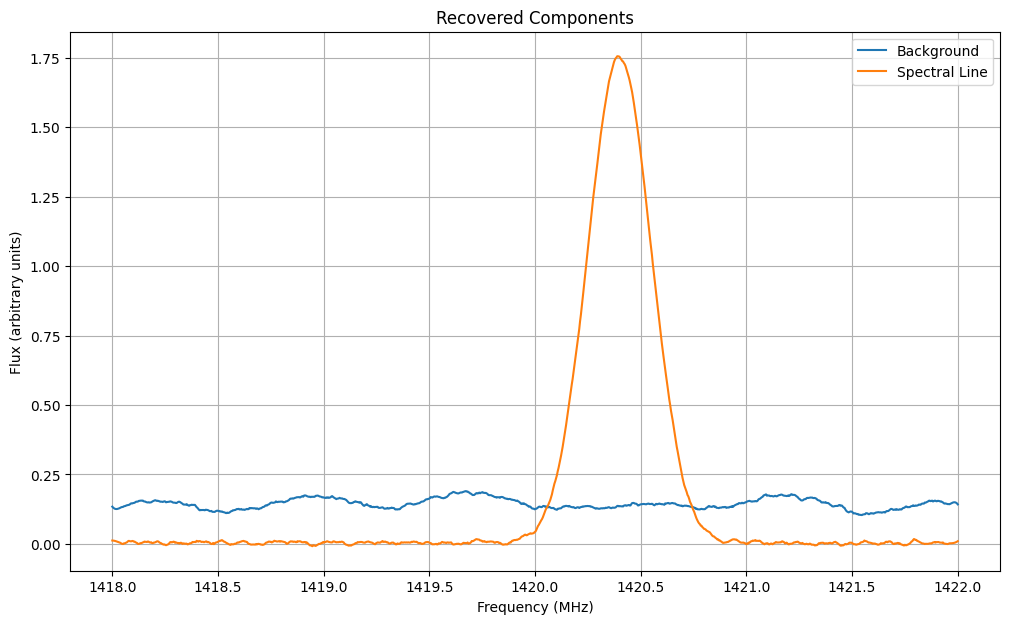

In [13]:
# The "Time Sources" (S) are in S_recovered (shape [200, 3])
# The "Spectral Shapes" (A) are in the .mixing_ array
A_recovered2 = ica2.mixing_

# --- 1. Calculate Kurtosis for Each Time Source ---
# We calculate kurtosis for each *column* (axis=0) of S_recovered
kurtosis_values2 = kurtosis(S_recovered2,axis=0)
for i in range(2):
    print(f"Component {i}: Kurtosis = {kurtosis_values2[i]:.4f}")

# --- 2. Automated Identification ---
# We use np.argmin and np.argmax to find the indices

# The Background is the "most Gaussian," so its kurtosis is closest to 0
background_index2 = np.argmin(np.abs(kurtosis_values2))
# The spectral line has the most negative kurtosis
spectral_index2 = np.argmin(kurtosis_values2)
# --- 3. Create Labeled Results ---
background_approach2 = A_recovered2[:,background_index2]
spectral_line_approach2 = A_recovered2[:,spectral_index2]

plt.figure(figsize=(12, 7))
plt.title("Recovered Components")
plt.plot(frequencies,background_approach2, label="Background")
plt.plot(frequencies,spectral_line_approach2, label="Spectral Line")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Flux (arbitrary units)")
plt.legend()
plt.grid(True)
plt.show()

--- Error Estimation ---
N2ormalized Root Mean Squared Error (NRMSE): 0.00328


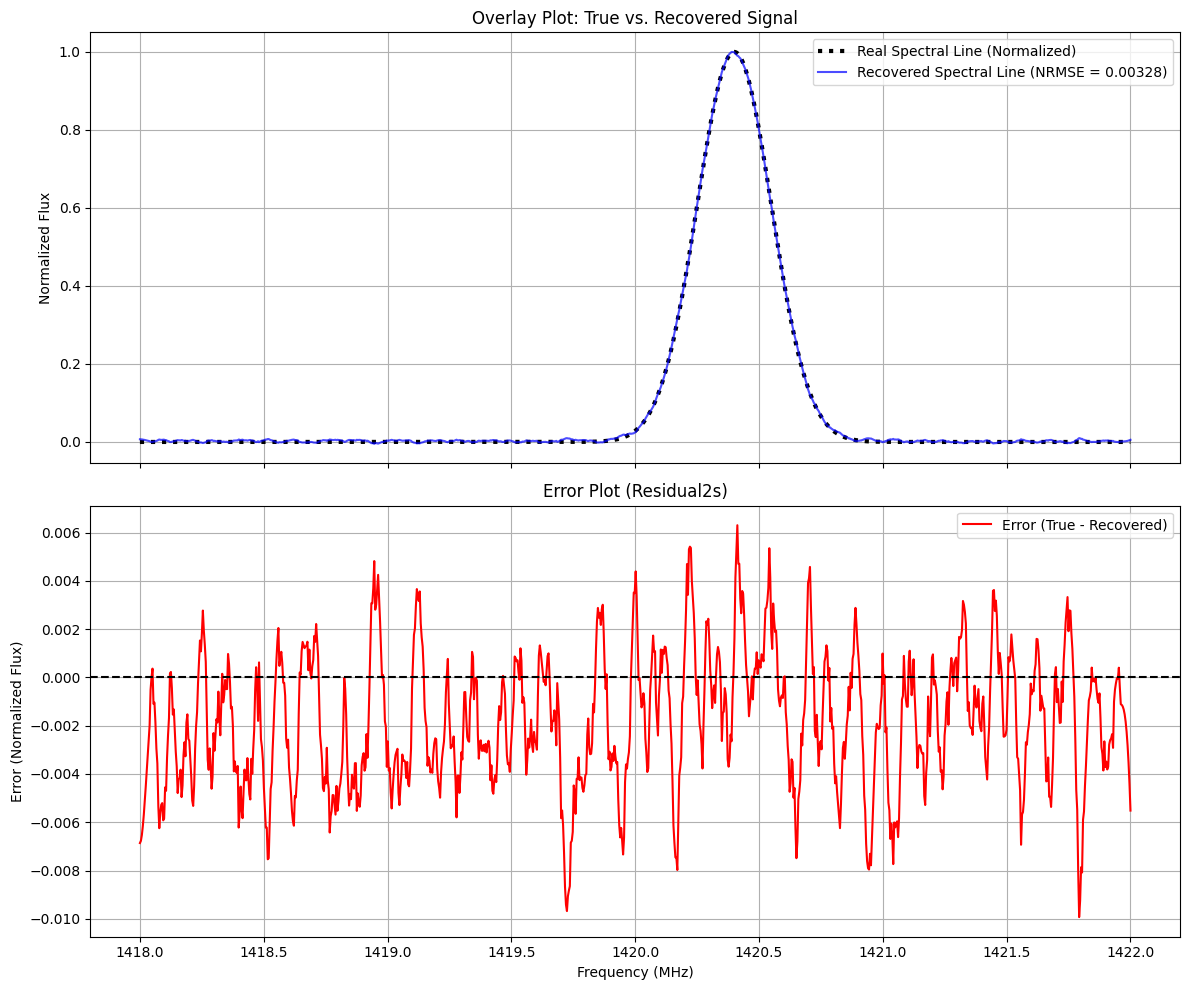

In [14]:
# Normalize the two signals
#spectral line
line_norm2 = line/np.max(line)
spectral_line_approach_norm2 = spectral_line_approach2/np.max(spectral_line_approach2)
rmse2 = np.sqrt(np.mean((line_norm2-spectral_line_approach_norm2)**2))
print(f"--- Error Estimation ---")
print(f"N2ormalized Root Mean Squared Error (NRMSE): {rmse2:.5f}")


# --- Plots ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
# Plot 1 : Overlay Plot
axes[0].set_title("Overlay Plot: True vs. Recovered Signal")
axes[0].plot(frequencies, line_norm2, 
             label="Real Spectral Line (Normalized)", 
             color='black', linestyle=':', linewidth=3)
axes[0].plot(frequencies, spectral_line_approach_norm2, 
             label=f"Recovered Spectral Line (NRMSE = {rmse2:.5f})", 
             color='blue', alpha=0.7)
axes[0].set_ylabel("Normalized Flux")
axes[0].legend()
axes[0].grid(True)

#Plot 2 : Residuals
residuals2 = line_norm2 - spectral_line_approach_norm2
axes[1].set_title("Error Plot (Residual2s)")
axes[1].plot(frequencies, residuals2, 
             label="Error (True - Recovered)", 
             color='red')
axes[1].axhline(0, color='black', linestyle='--') 
axes[1].set_xlabel("Frequency (MHz)")
axes[1].set_ylabel("Error (Normalized Flux)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

--- Error Estimation ---
Normalized Root Mean Squared Error (NRMSE): 0.07807


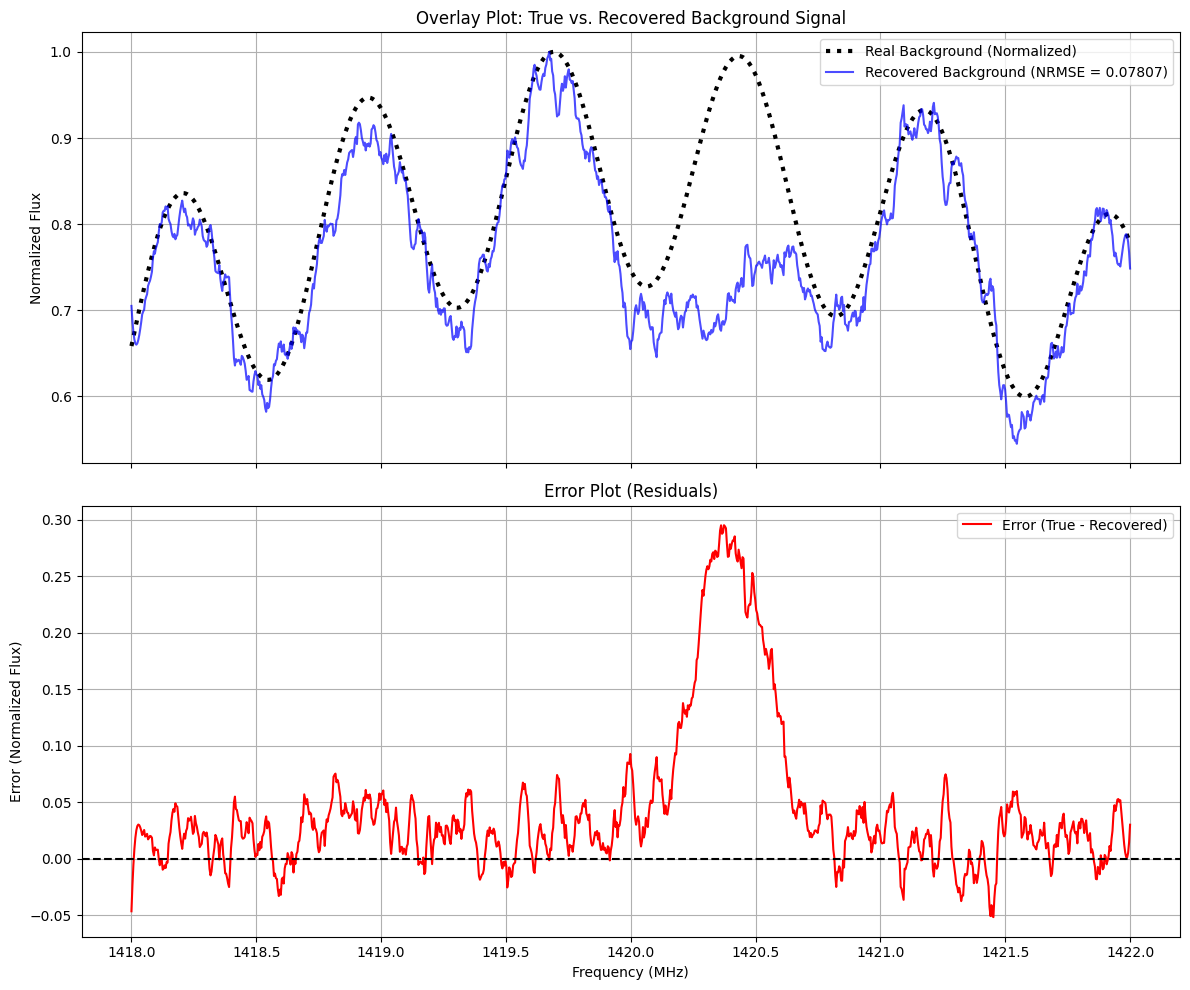

In [15]:
# Normalize the two signals
#Background Signal
background_norm2 = background/np.max(background)
background_approach_norm2 = background_approach2/np.max(background_approach2)
rmse_background2 = np.sqrt(np.mean((background_norm2-background_approach_norm2)**2))
print(f"--- Error Estimation ---")
print(f"Normalized Root Mean Squared Error (NRMSE): {rmse_background2:.5f}")


# --- Plots ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
# Plot 1 : Overlay Plot
axes[0].set_title("Overlay Plot: True vs. Recovered Background Signal")
axes[0].plot(frequencies, background_norm2, 
             label="Real Background (Normalized)", 
             color='black', linestyle=':', linewidth=3)
axes[0].plot(frequencies, background_approach_norm2, 
             label=f"Recovered Background (NRMSE = {rmse_background2:.5f})", 
             color='blue', alpha=0.7)
axes[0].set_ylabel("Normalized Flux")
axes[0].legend()
axes[0].grid(True)

#Plot 2 : Residuals
residuals2 = background_norm2 - background_approach_norm2
axes[1].set_title("Error Plot (Residuals)")
axes[1].plot(frequencies, residuals2, 
             label="Error (True - Recovered)", 
             color='red')
axes[1].axhline(0, color='black', linestyle='--') 
axes[1].set_xlabel("Frequency (MHz)")
axes[1].set_ylabel("Error (Normalized Flux)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### Add a Strong Tip in the signal 